# Bootstrapping
Bootstrapping is a powerful statistical tool that helps us to **measure the uncertainty** in the prediction of a model. In this activity, we implement this technique to **assess variations** in the prediction of KNN classifier. In **Assignment Task 2.B.**, you will be asked to expand this example and develop a bootstrap procedure for KNN as a regressor. 

# Steps for Activity 1.2
<ol>
	<li>Load the training dataset,</li>
    <li>Implement bootstrap sampling,</li>
	<li>Apply <code>bootstrap </code>function <code> with times = 40</code> (the number of samples) <code>and size = 50 </code> (the size of each sample) on <code>knn </code>for $K\in{1,\dots,30}$,</li>
	<li>Report the uncertainty in the prediction in percentages.</li>
	<li>Repeat Step 2 with different values of K, times and size.</li>
</ol>

# Implementation of the Above Steps

In [17]:
# load libraries:
library(reshape2)
library(ggplot2)

In [18]:
# Load data:
library(datasets)
data(iris)

In [25]:
# permute iris:
iris <- iris[sample(1:nrow(iris),nrow(iris)),]
# create training and testing datasets:
train.index = 1:100
train.data <- iris[train.index, -5]
train.label <- iris[train.index, 5]
test.data <- iris[-train.index, -5]
test.label <- iris[-train.index, 5]

In [49]:
test.label

[1] versicolor virginica  virginica  versicolor virginica  versicolor
 [7] virginica  versicolor versicolor versicolor virginica  virginica 
[13] setosa     versicolor virginica  setosa     virginica  virginica 
[19] versicolor setosa     virginica  versicolor setosa     versicolor
[25] versicolor virginica  virginica  virginica  versicolor versicolor
[31] virginica  setosa     setosa     setosa     setosa     versicolor
[37] setosa     versicolor virginica  setosa     versicolor setosa    
[43] versicolor setosa     setosa     versicolor setosa     setosa    
[49] setosa     virginica 
Levels: setosa versicolor virginica

In [26]:
nrow(train.data)

[1] 100

bootstrapping is a technique for **resampling**. It **randomly draws data from the original dataset with replacement**, so that some data in the original dataset may be **replicated** in the newly sampling.  
This process can be repeated $L$ times to generate $L$ datasets.  
There are two parameters that must be chosen when performing the bootstrap: 
1. $N$: The size of the sample 
2. $L$: The number of repetitions of the procedure to perform.(how many time to do resampling)

In [20]:
# define a function that generates sample indixes based on bootstrap technique
boot <- function (original.size=100, sample.size=original.size, times=100){
    # Create an empty data.frame ready for the resampling
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}
# just to see if it works!
boot(100, 10, 5)
# 5 times resampling
# each time resample 10 data
# from original dataset (size=100)

74,54,96,60,20,63,33,82,97,42
8,22,31,95,29,31,93,30,24,44
29,6,58,20,8,3,68,35,45,89
52,55,34,92,46,90,56,95,17,8
88,85,11,8,51,34,44,94,15,24


## Application in KNN Classifer 

In [27]:
# This is the KNN classifer that we implemented in Activity 1.1

# define a function that calculates the majority votes (or mode!)
majority <- function(x) {
   uniqx <- unique(x)
   uniqx[which.max(tabulate(match(x, uniqx)))]
}

# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    train.len <- nrow(train.data); test.len <- nrow(test.data)
    # calculate the distance
    temp <- as.matrix(dist(rbind(test.data, train.data), method= distance))
    dist <- temp[1:test.len, (test.len+1):(test.len+train.len)]
    
    for (i in 1:test.len){
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        test.label[i] <- majority(train.label[nn])
    }
    return (test.label)
}

## Experiment

In [74]:
# fix the parameters (50,40,50)
K <- 20           # Maximum K for KNN 
L <- 30           # number of resampling datasets
N <- 50           # size of each resampling datasets

# generate bootstrap indices:
# boot(original.size, sample.size, times)
boot.indx <- boot(nrow(train.data), N, L)
# a dataframe to track the number of missclassified samples in each case
miss <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(NA,L*K))

In [75]:
## THIS MAY TAKE A FEW MINUTES TO COMPLETE
## for every k values:
for (k in 1: K){
    # for every resampling dataset, do knn
    for (l in 1:L){
        # calculate iteration index i
        i <- (k-1)*L + l
        # k=1, i=1,2,...,L; k=2, i=L+1, L+2, ..., L+l; k=K, (K-1)L+1, (K-1)L+2, ..., K*L,
        
        # take resample indices from bootstrap
        indx <- boot.indx[l,] 
        
        # record the value of k and l
        miss[i,'K'] <- k
        miss[i,'L'] <- l
        
        # do knn
        knn_result = knn(train.data[indx, ], train.label[indx], test.data, K=k)
        
        # calculate and record the train and test missclassification rates
        miss[i,'test'] <-  sum(knn_result != test.label)/nrow(test.data)*100
    } 
}

### Visalization
Let check the output. In the following Jitter Plot, each point corrspends to the error (measured on the fixed test set) of the KNN classifier (which trained by a randomly resampled datasets from bootstrap). 

`melt()`:

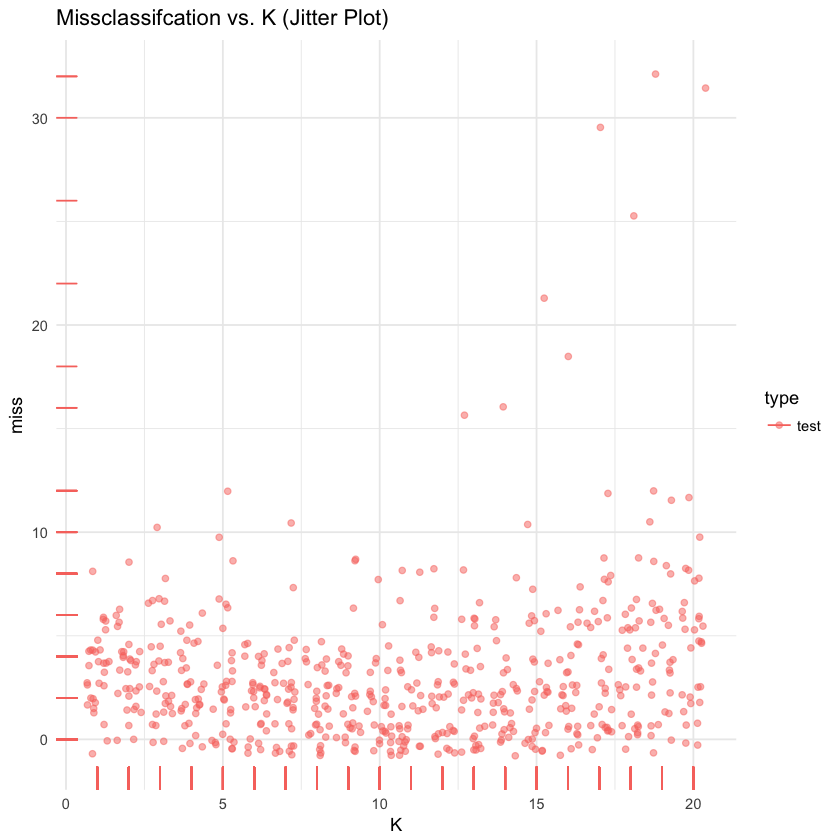

In [76]:
# reshape for visualization
miss.m <- melt(miss, id=c('K', 'L')) 
names(miss.m) <- c('K', 'L', 'type', 'miss')

# plot misclassification percentage for train and test data sets
ggplot(data=miss.m, aes(x=K, miss, color=type)) + geom_jitter(alpha=0.5)  + 
    scale_fill_discrete(guide = guide_legend(title = NULL)) + geom_rug() +
    ggtitle('Missclassifcation vs. K (Jitter Plot)') + theme_minimal() 

From above, we can find that: 
- when K increases, the complexity decreases. As a result, the model becomes too simple, the error rate hence increases.

---

Now we produce the box plot of the error numbers (each of which corresponding to a sample in our bootstrap sampling) we have obtained for our test set for each value of K. 

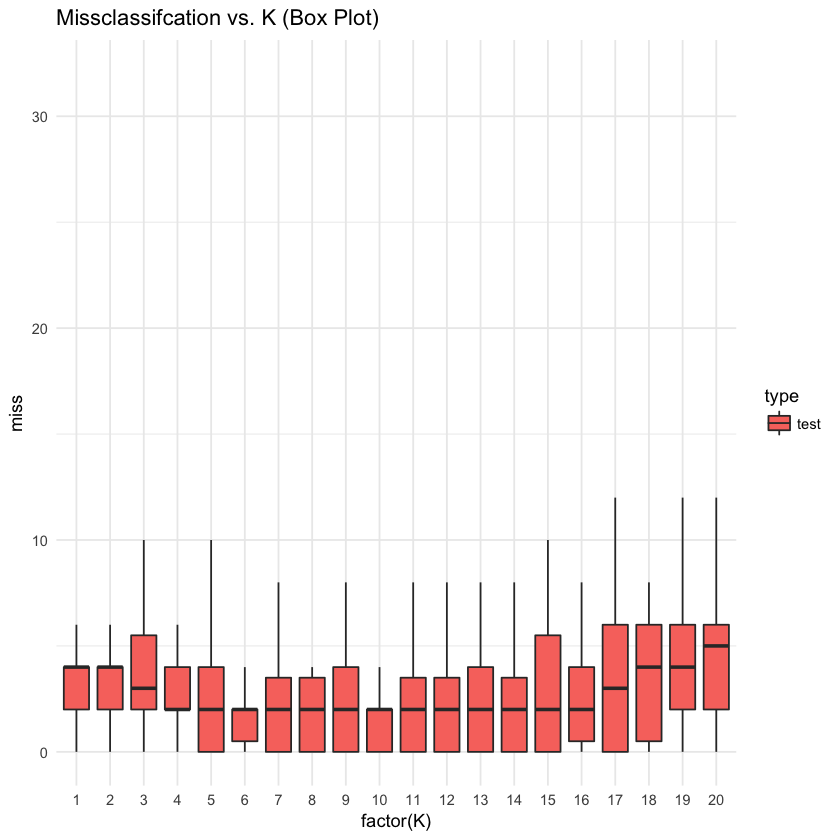

In [77]:
ggplot(data=miss.m[miss.m$type=='test',], aes(factor(K), miss,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Box Plot)') + theme_minimal()
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

# Discussions
- As $K$ increases, how does the test error and its uncertainty behave (represented by the boxplots)? 
  
> As k increases, test error rate increases as well as the variance. It indicates that when K becomes larger, the uncertainty will be more larger.

- Rerun the above experiments for other values of `times` and `size`, then explain how increasing the number of samples and the size of each sample affect the error uncertainty.

> When the size of each sample is fixed, the larger resample size will result in smaller error rate.  
> WHen the number of resample datasets is fixed, the smaller size of each dataset, the larger the error rate.

* Q: When resampling size >> the original dataset, the error rate become smaller in large K. Is it true because the training dataset has become large where somehow fit with a larger K? Otherwise why?

> No! The size of resampling dataset should not be larger than the original dataset. Otherwise, the result will be incorrect.

[Size of bootstrap samples: Answered by Tim](https://stats.stackexchange.com/a/246734)